In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import pandas as pd

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION_v2"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load Database

In [2]:
signals, annotations, signalsMetadata = loadCOGNITIONSpindles_v2(cognipath,returnSignals=True)

In [3]:
annotations

subjectId channel     startTime      stopTime  duration  phase     type  \
0        COG001      F3   1798.073930   1798.696491  0.622561      2  spindle   
1        COG001      F3   1868.599222   1869.591433  0.992211      2  spindle   
2        COG001      F3   1914.163425   1915.369645  1.206220      2  spindle   
3        COG001      F3   1916.653694   1917.840459  1.186765      2  spindle   
4        COG001      F3   1928.638133   1929.902718  1.264585      2  spindle   
...         ...     ...           ...           ...       ...    ...      ...   
14684    COG009      C4  35328.677042  35329.338519  0.661477      3  spindle   
14685    COG009      C4  35440.817120  35441.575876  0.758756      3  spindle   
14686    COG009      C4  35521.498055  35522.373535  0.875480      3  spindle   
14687    COG009      C4  39504.552529  39505.077815  0.525286      3  spindle   
14688    COG009      C4  39549.844358  39552.081712  2.237354      3  spindle   

       samplerate  startInd  stopInd  
0             200    359615   359739  
1             200    373720   373918  
2             200    382833   383074  
3             200    383331   383568  
4             200    385728   385981  
...           ...       ...      ...  
14684         200   7065735  7065868  
14685         200   7088163  7088315  
14686         200   7104300  7104475  
14687         200   7900911  7901016  
14688         200   7909969  7910416  

[14689 rows x 10 columns]

(array([2058., 4605., 3723., 2061., 1201.,  556.,  290.,  126.,   51.,
          18.]),
 array([0.447467 , 0.7081683, 0.9688696, 1.2295709, 1.4902722, 1.7509735,
        2.0116748, 2.2723761, 2.5330774, 2.7937787, 3.05448  ]),
 <BarContainer object of 10 artists>)

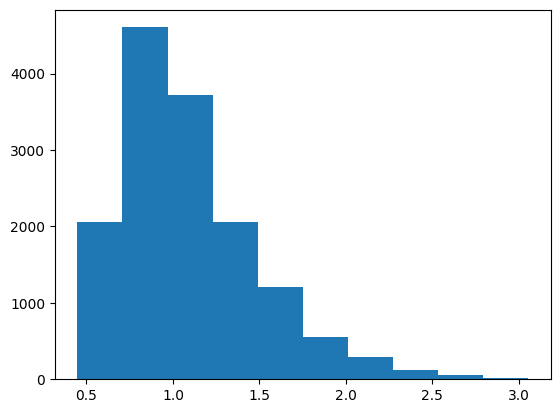

In [10]:
plt.hist(annotations.duration)

## spindle duration histograms

In [11]:
spindles=annotations[annotations.type=='spindle'].copy()

In [12]:
len(spindles)

14689

In [13]:
print("spindles longer than 3s: "+ str(np.sum(spindles.duration>3)))

print("longest spindle (s): "+str(np.max(spindles.duration)))

spindles longer than 3s: 3
longest spindle (s): 3.05448


In [14]:
print("spindles shorter than 0.5s: "+ str(np.sum(spindles.duration<0.5)))

print("shortest spindle (s): "+str(np.min(spindles.duration)))

spindles shorter than 0.5s: 12
shortest spindle (s): 0.447467


In [15]:
aux=annotations[["type","subjectId","channel"]].groupby(["type","subjectId","channel"],as_index=False).size()
px.bar(aux,x="subjectId",y="size",color="channel",barmode="group",facet_row="type",title="COGNITION annotations overview")

In [16]:
px.histogram(spindles,x='duration',title="COGNITION spindle duration histogram")

In [17]:
px.histogram(spindles,x='duration',color="subjectId",facet_col="channel",title="COGNITION spindle duration histogram by signal")

### Some data

In [21]:
sizeBySubject=spindles[['subjectId','startTime']].groupby(['subjectId'],as_index=False).size()
sizeBySubject

subjectId  size
0    COG001  2283
1    COG002   625
2    COG003  2912
3    COG004  1908
4    COG005  3084
5    COG006  1335
6    COG007  1507
7    COG008   457
8    COG009   578

In [26]:
aux=spindles[['subjectId','channel','startTime']].groupby(['subjectId','channel'],as_index=False).size()
aux

subjectId channel  size
0     COG001      C3   214
1     COG001      C4   232
2     COG001      F3   984
3     COG001      F4   853
4     COG002      C3   240
5     COG002      C4   110
6     COG002      F3   173
7     COG002      F4   102
8     COG003      C3   849
9     COG003      C4  1162
10    COG003      F3   338
11    COG003      F4   563
12    COG004      C3   419
13    COG004      C4   273
14    COG004      F3   644
15    COG004      F4   572
16    COG005      C3   316
17    COG005      C4   289
18    COG005      F3  1539
19    COG005      F4   940
20    COG006      C3   226
21    COG006      C4   108
22    COG006      F3   539
23    COG006      F4   462
24    COG007      C3   372
25    COG007      C4    49
26    COG007      F3   503
27    COG007      F4   583
28    COG008      C3    47
29    COG008      C4   125
30    COG008      F3   113
31    COG008      F4   172
32    COG009      C3   102
33    COG009      C4    31
34    COG009      F3   206
35    COG009      F4   239

In [27]:
aux=pd.merge(sizeBySubject,aux,on='subjectId')

In [29]:
aux['percentageSpindles']=aux.size_y/aux.size_x

In [30]:
aux

subjectId  size_x channel  size_y  percentageSpindles
0     COG001    2283      C3     214            0.093736
1     COG001    2283      C4     232            0.101621
2     COG001    2283      F3     984            0.431012
3     COG001    2283      F4     853            0.373631
4     COG002     625      C3     240            0.384000
5     COG002     625      C4     110            0.176000
6     COG002     625      F3     173            0.276800
7     COG002     625      F4     102            0.163200
8     COG003    2912      C3     849            0.291552
9     COG003    2912      C4    1162            0.399038
10    COG003    2912      F3     338            0.116071
11    COG003    2912      F4     563            0.193338
12    COG004    1908      C3     419            0.219602
13    COG004    1908      C4     273            0.143082
14    COG004    1908      F3     644            0.337526
15    COG004    1908      F4     572            0.299790
16    COG005    3084      C3     316            0.102464
17    COG005    3084      C4     289            0.093709
18    COG005    3084      F3    1539            0.499027
19    COG005    3084      F4     940            0.304799
20    COG006    1335      C3     226            0.169288
21    COG006    1335      C4     108            0.080899
22    COG006    1335      F3     539            0.403745
23    COG006    1335      F4     462            0.346067
24    COG007    1507      C3     372            0.246848
25    COG007    1507      C4      49            0.032515
26    COG007    1507      F3     503            0.333776
27    COG007    1507      F4     583            0.386861
28    COG008     457      C3      47            0.102845
29    COG008     457      C4     125            0.273523
30    COG008     457      F3     113            0.247265
31    COG008     457      F4     172            0.376368
32    COG009     578      C3     102            0.176471
33    COG009     578      C4      31            0.053633
34    COG009     578      F3     206            0.356401
35    COG009     578      F4     239            0.413495

### Spindle properties

In [62]:
def getSpindleMedianFreq(signals,row):
    excerpt=signals[row.subjectId][row.channel][row.startInd:row.stopInd]
    freqs, values = tapperAndGetPSD(excerpt,row.samplerate,returnFreqs=True)
    roiFreq=[11,16]
    values=values[(freqs>roiFreq[0])&(freqs<roiFreq[1])]
    freqs=freqs[(freqs>roiFreq[0])&(freqs<roiFreq[1])]
    values=values/np.sum(values)
    median = getMedianPSDIndex(values)
    return freqs[median]

In [37]:
row=spindles.iloc[0]
row

subjectId          COG001
channel                F3
startTime      1798.07393
stopTime      1798.696491
duration         0.622561
phase                   2
type              spindle
samplerate            200
startInd           359615
stopInd            359739
Name: 0, dtype: object

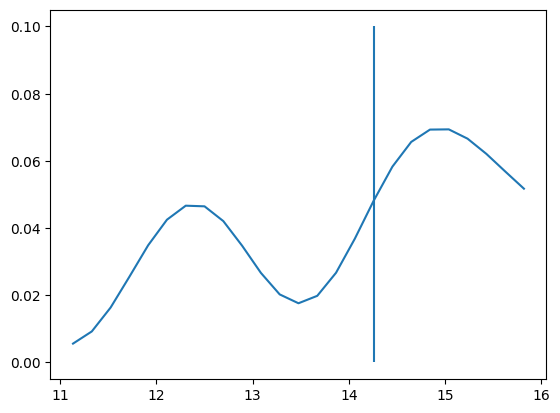

In [58]:
excerpt=signals[row.subjectId][row.channel][row.startInd:row.stopInd]
freqs, values = tapperAndGetPSD(excerpt,row.samplerate,returnFreqs=True)
roiFreq=[11,16]
values=values[(freqs>roiFreq[0])&(freqs<roiFreq[1])]
freqs=freqs[(freqs>roiFreq[0])&(freqs<roiFreq[1])]
values=values/np.sum(values)
median = getMedianPSDIndex(values)
plt.plot(freqs,values)
plt.vlines(freqs[median],0,0.1)

In [63]:
spindles['medianFrequency']=spindles.apply(lambda row: getSpindleMedianFreq(signals,row),axis=1)

In [121]:
spindles

subjectId channel     startTime      stopTime  duration  phase     type  \
0        COG001      F3   1798.073930   1798.696491  0.622561      2  spindle   
1        COG001      F3   1868.599222   1869.591433  0.992211      2  spindle   
2        COG001      F3   1914.163425   1915.369645  1.206220      2  spindle   
3        COG001      F3   1916.653694   1917.840459  1.186765      2  spindle   
4        COG001      F3   1928.638133   1929.902718  1.264585      2  spindle   
...         ...     ...           ...           ...       ...    ...      ...   
14684    COG009      C4  35328.677042  35329.338519  0.661477      3  spindle   
14685    COG009      C4  35440.817120  35441.575876  0.758756      3  spindle   
14686    COG009      C4  35521.498055  35522.373535  0.875480      3  spindle   
14687    COG009      C4  39504.552529  39505.077815  0.525286      3  spindle   
14688    COG009      C4  39549.844358  39552.081712  2.237354      3  spindle   

       samplerate  startInd  stopInd  medianFrequency        power  
0             200    359615   359739        14.257812   191.414827  
1             200    373720   373918        12.890625   317.079827  
2             200    382833   383074        11.718750   173.375277  
3             200    383331   383568        12.109375  1084.544910  
4             200    385728   385981        13.867188    85.108607  
...           ...       ...      ...              ...          ...  
14684         200   7065735  7065868        11.718750   540.729166  
14685         200   7088163  7088315        11.718750  1326.316176  
14686         200   7104300  7104475        11.523438   739.707230  
14687         200   7900911  7901016        11.718750  1239.894304  
14688         200   7909969  7910416        11.718750   519.539075  

[14689 rows x 12 columns]

In [70]:
px.violin(spindles,x="channel",y="medianFrequency",box=True,color="subjectId")

In [71]:
def getSpindlePower(signals,row):
    excerpt=signals[row.subjectId][row.channel][row.startInd:row.stopInd]
    freqs, values = tapperAndGetPSD(excerpt,row.samplerate,returnFreqs=True)
    roiFreq=[11,16]
    values=values[(freqs>roiFreq[0])&(freqs<roiFreq[1])]
    return np.sum(values)

In [72]:
spindles['power']=spindles.apply(lambda row: getSpindlePower(signals,row),axis=1)

In [73]:
px.violin(spindles,x="channel",y="power",box=True,color="subjectId")

### Spindle frequency by channel

In [126]:
aux1=spindles[['subjectId','channel','medianFrequency']].groupby(['subjectId','channel'],as_index=False).mean()
aux1

subjectId channel  medianFrequency
0     COG001      C3        12.141319
1     COG001      C4        12.263436
2     COG001      F3        11.806680
3     COG001      F4        11.807591
4     COG002      C3        13.053385
5     COG002      C4        13.027344
6     COG002      F3        12.423230
7     COG002      F4        12.446385
8     COG003      C3        12.024026
9     COG003      C4        12.087524
10    COG003      F3        11.885170
11    COG003      F4        11.990730
12    COG004      C3        12.494406
13    COG004      C4        12.409856
14    COG004      F3        12.120900
15    COG004      F4        12.149667
16    COG005      C3        12.742904
17    COG005      C4        12.735186
18    COG005      F3        12.127396
19    COG005      F4        12.027926
20    COG006      C3        13.462735
21    COG006      C4        13.492839
22    COG006      F3        12.856201
23    COG006      F4        13.000541
24    COG007      C3        12.762517
25    COG007      C4        12.771046
26    COG007      F3        12.439038
27    COG007      F4        12.476549
28    COG008      C3        12.524934
29    COG008      C4        12.581250
30    COG008      F3        12.415307
31    COG008      F4        12.568132
32    COG009      C3        12.308517
33    COG009      C4        11.977067
34    COG009      F3        11.729179
35    COG009      F4        11.867482

In [127]:
px.bar(aux1,x='subjectId',y='medianFrequency',color='channel',barmode="group")

### Spindle power by channel

In [128]:
aux2=spindles[['subjectId','channel','power']].groupby(['subjectId','channel'],as_index=False).median()
aux2

subjectId channel       power
0     COG001      C3   92.466643
1     COG001      C4   75.947756
2     COG001      F3  234.750083
3     COG001      F4  188.003908
4     COG002      C3   93.059063
5     COG002      C4  156.744192
6     COG002      F3  503.135595
7     COG002      F4  321.199119
8     COG003      C3  121.072074
9     COG003      C4   89.098762
10    COG003      F3  500.051702
11    COG003      F4  279.475894
12    COG004      C3   49.728120
13    COG004      C4   69.809609
14    COG004      F3  179.510774
15    COG004      F4  165.102029
16    COG005      C3  104.089783
17    COG005      C4   77.426990
18    COG005      F3  480.622146
19    COG005      F4  416.589498
20    COG006      C3  115.037949
21    COG006      C4  256.020374
22    COG006      F3  714.513725
23    COG006      F4  489.150719
24    COG007      C3  236.463478
25    COG007      C4  716.315355
26    COG007      F3  324.156543
27    COG007      F4  276.966541
28    COG008      C3  192.005902
29    COG008      C4  173.930830
30    COG008      F3  366.416949
31    COG008      F4  228.402875
32    COG009      C3  152.791453
33    COG009      C4  551.247579
34    COG009      F3  594.149772
35    COG009      F4  389.655567

In [130]:
px.bar(aux2,x='subjectId',y='power',color='channel',barmode="group")

### Spindle density by channel

In [131]:
aux=spindles[['subjectId','channel','startTime']].groupby(['subjectId','channel'],as_index=False).size()
aux

subjectId channel  size
0     COG001      C3   214
1     COG001      C4   232
2     COG001      F3   984
3     COG001      F4   853
4     COG002      C3   240
5     COG002      C4   110
6     COG002      F3   173
7     COG002      F4   102
8     COG003      C3   849
9     COG003      C4  1162
10    COG003      F3   338
11    COG003      F4   563
12    COG004      C3   419
13    COG004      C4   273
14    COG004      F3   644
15    COG004      F4   572
16    COG005      C3   316
17    COG005      C4   289
18    COG005      F3  1539
19    COG005      F4   940
20    COG006      C3   226
21    COG006      C4   108
22    COG006      F3   539
23    COG006      F4   462
24    COG007      C3   372
25    COG007      C4    49
26    COG007      F3   503
27    COG007      F4   583
28    COG008      C3    47
29    COG008      C4   125
30    COG008      F3   113
31    COG008      F4   172
32    COG009      C3   102
33    COG009      C4    31
34    COG009      F3   206
35    COG009      F4   239

In [132]:
aux=pd.merge(signalsMetadata,aux,on=["subjectId","channel"])
aux["density"]=aux["size"]/(aux["duration"]/3600)

In [133]:
aux=pd.merge(aux,aux1,on=["subjectId","channel"])


In [134]:
aux=pd.merge(aux,aux2,on=["subjectId","channel"])
aux

filename subjectId channel  duration  samplerate  \
0   COG001_F3.pkl    COG001      F3   39600.0         200   
1   COG001_C3.pkl    COG001      C3   39600.0         200   
2   COG001_F4.pkl    COG001      F4   39600.0         200   
3   COG001_C4.pkl    COG001      C4   39600.0         200   
4   COG002_F3.pkl    COG002      F3   39600.0         200   
5   COG002_C3.pkl    COG002      C3   39600.0         200   
6   COG002_F4.pkl    COG002      F4   39600.0         200   
7   COG002_C4.pkl    COG002      C4   39600.0         200   
8   COG003_F3.pkl    COG003      F3   39600.0         200   
9   COG003_C3.pkl    COG003      C3   39600.0         200   
10  COG003_F4.pkl    COG003      F4   39600.0         200   
11  COG003_C4.pkl    COG003      C4   39600.0         200   
12  COG004_F3.pkl    COG004      F3   39600.0         200   
13  COG004_C3.pkl    COG004      C3   39600.0         200   
14  COG004_F4.pkl    COG004      F4   39600.0         200   
15  COG004_C4.pkl    COG004      C4   39600.0         200   
16  COG005_F3.pkl    COG005      F3   39600.0         200   
17  COG005_C3.pkl    COG005      C3   39600.0         200   
18  COG005_F4.pkl    COG005      F4   39600.0         200   
19  COG005_C4.pkl    COG005      C4   39600.0         200   
20  COG006_F3.pkl    COG006      F3   39600.0         200   
21  COG006_C3.pkl    COG006      C3   39600.0         200   
22  COG006_F4.pkl    COG006      F4   39600.0         200   
23  COG006_C4.pkl    COG006      C4   39600.0         200   
24  COG007_F3.pkl    COG007      F3   39600.0         200   
25  COG007_C3.pkl    COG007      C3   39600.0         200   
26  COG007_F4.pkl    COG007      F4   39600.0         200   
27  COG007_C4.pkl    COG007      C4   39600.0         200   
28  COG008_F3.pkl    COG008      F3   39600.0         200   
29  COG008_C3.pkl    COG008      C3   39600.0         200   
30  COG008_F4.pkl    COG008      F4   39600.0         200   
31  COG008_C4.pkl    COG008      C4   39600.0         200   
32  COG009_F3.pkl    COG009      F3   39600.0         200   
33  COG009_C3.pkl    COG009      C3   39600.0         200   
34  COG009_F4.pkl    COG009      F4   39600.0         200   
35  COG009_C4.pkl    COG009      C4   39600.0         200   

    isOriginalSamplerate      database  size     density  medianFrequency  \
0                  False  COGNITION_v2   984   89.454545        11.806680   
1                  False  COGNITION_v2   214   19.454545        12.141319   
2                  False  COGNITION_v2   853   77.545455        11.807591   
3                  False  COGNITION_v2   232   21.090909        12.263436   
4                  False  COGNITION_v2   173   15.727273        12.423230   
5                  False  COGNITION_v2   240   21.818182        13.053385   
6                  False  COGNITION_v2   102    9.272727        12.446385   
7                  False  COGNITION_v2   110   10.000000        13.027344   
8                  False  COGNITION_v2   338   30.727273        11.885170   
9                  False  COGNITION_v2   849   77.181818        12.024026   
10                 False  COGNITION_v2   563   51.181818        11.990730   
11                 False  COGNITION_v2  1162  105.636364        12.087524   
12                 False  COGNITION_v2   644   58.545455        12.120900   
13                 False  COGNITION_v2   419   38.090909        12.494406   
14                 False  COGNITION_v2   572   52.000000        12.149667   
15                 False  COGNITION_v2   273   24.818182        12.409856   
16                 False  COGNITION_v2  1539  139.909091        12.127396   
17                 False  COGNITION_v2   316   28.727273        12.742904   
18                 False  COGNITION_v2   940   85.454545        12.027926   
19                 False  COGNITION_v2   289   26.272727        12.735186   
20                 False  COGNITION_v2   539   49.000000        12.856201   
21                 False  COGNITION_v2   226   20.545455 

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_6060\2630994023.py:14: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_6060\2630994023.py:15: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_6060\2630994023.py:14: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value

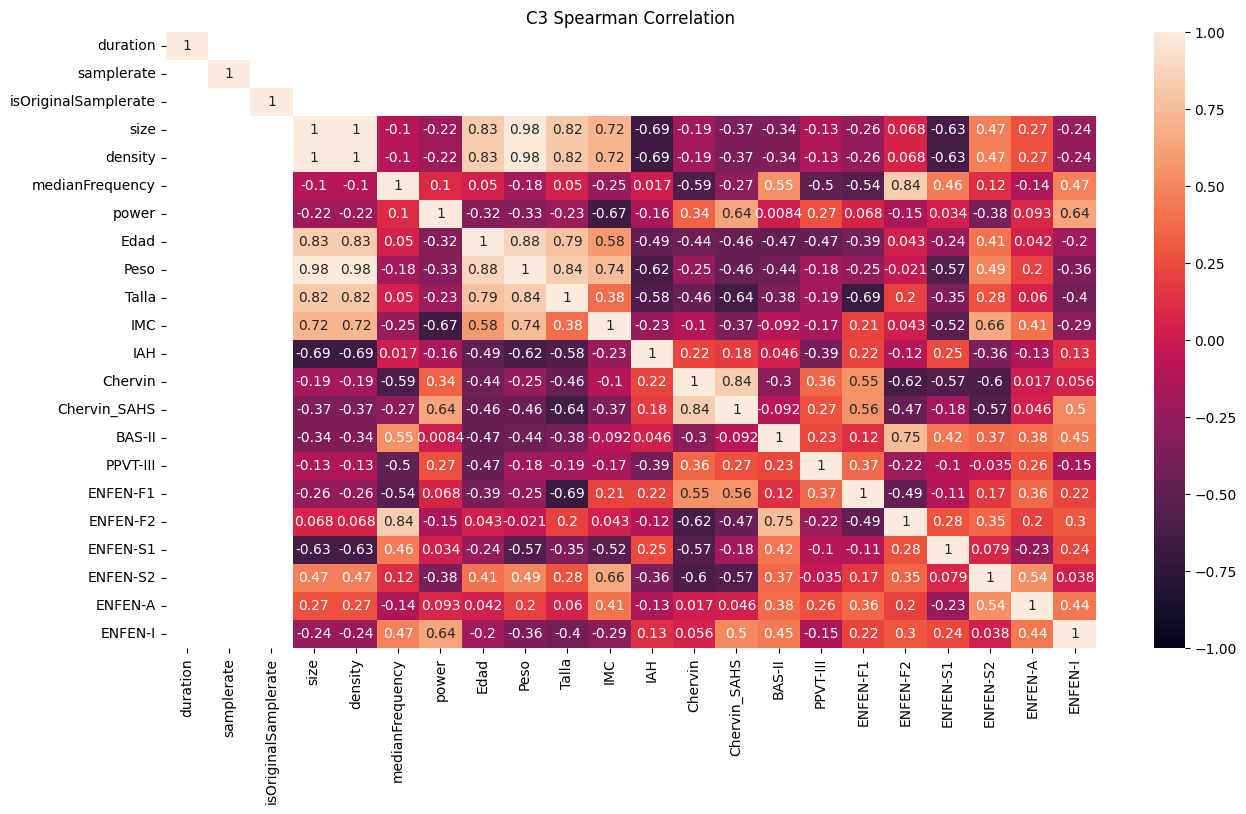

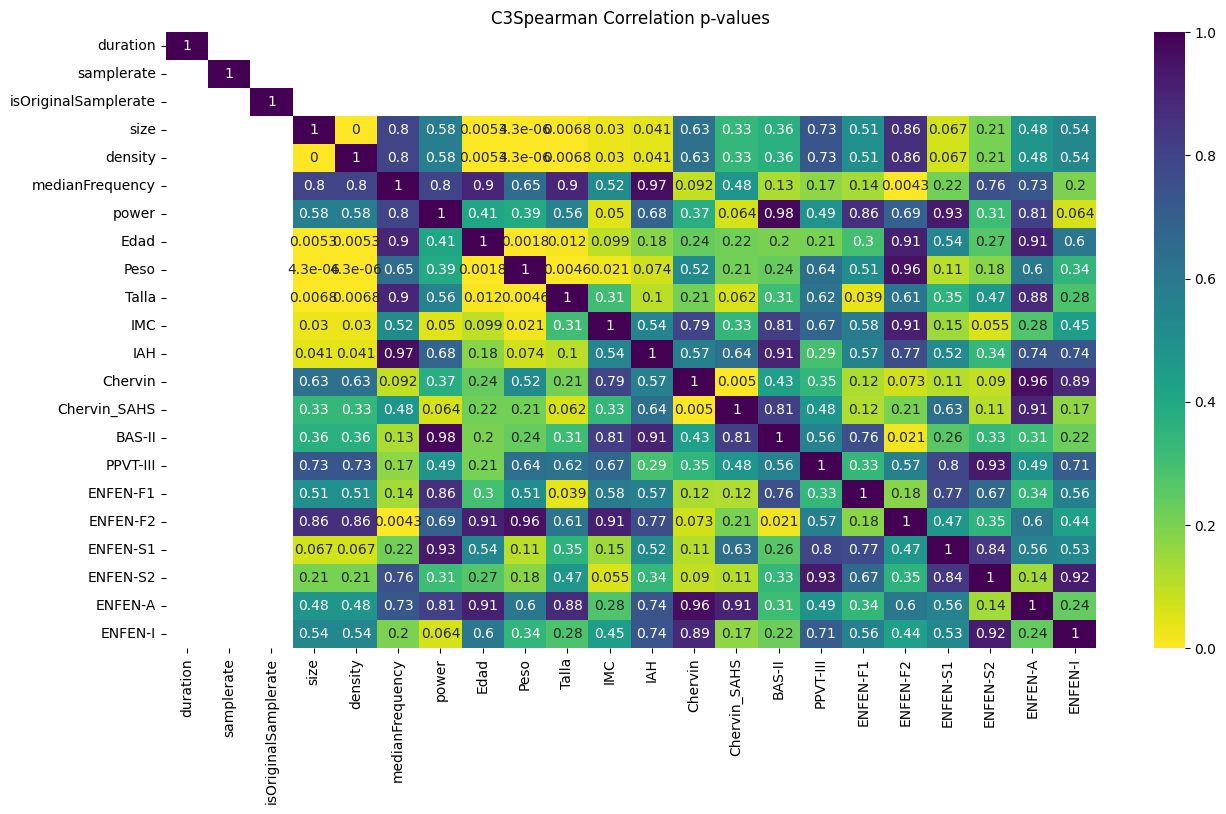

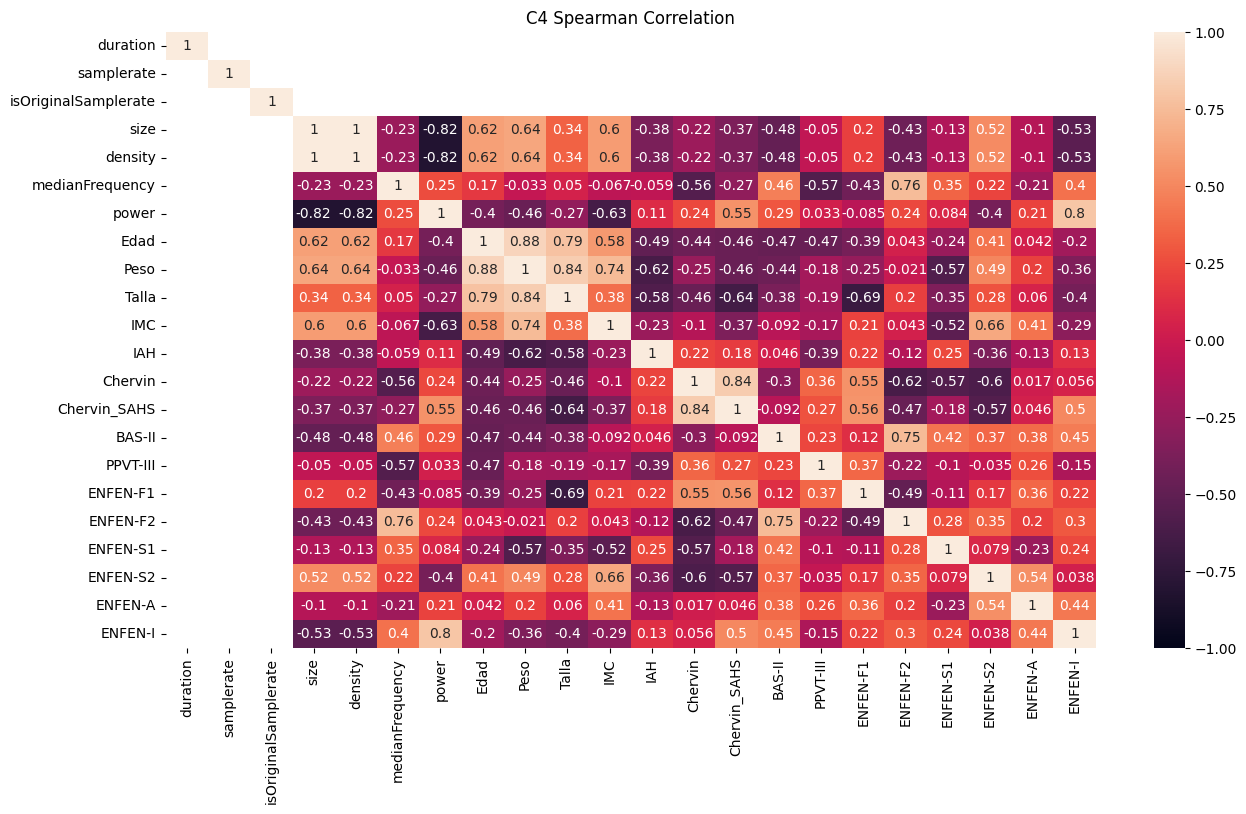

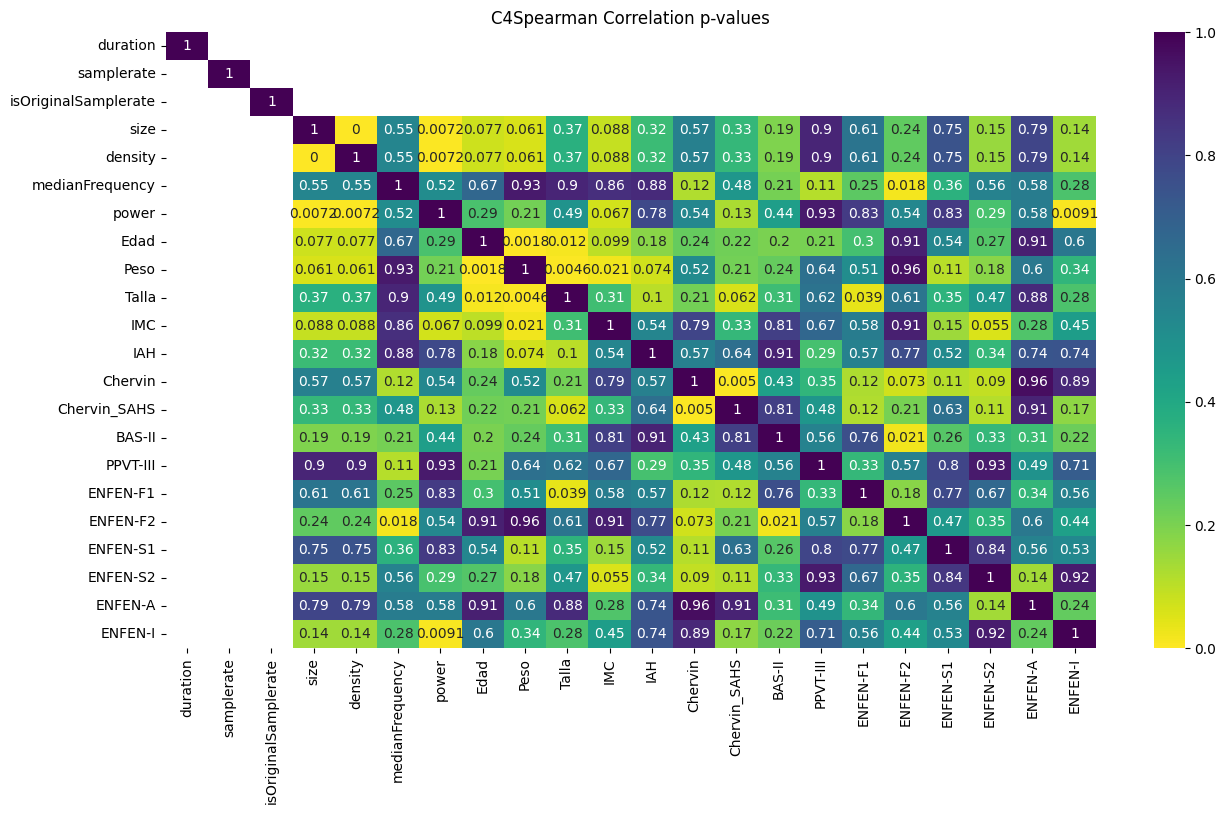

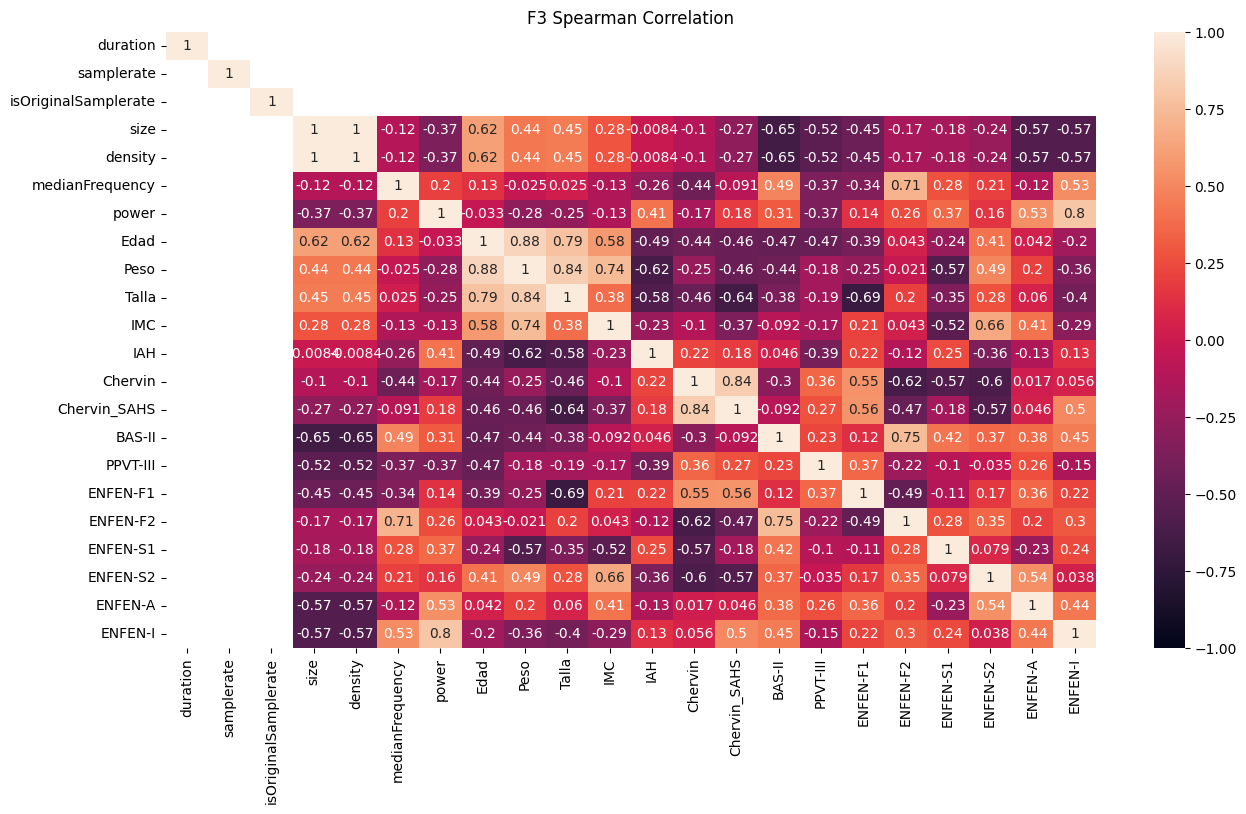

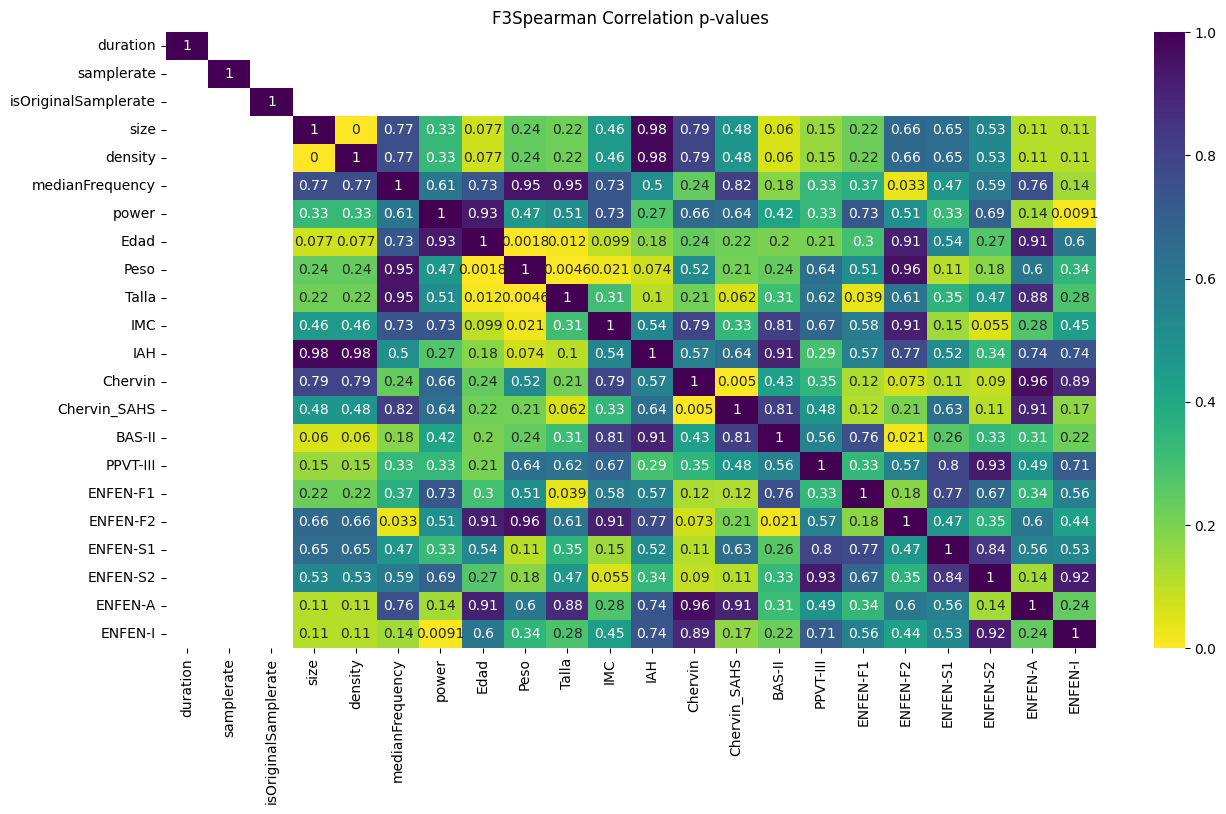

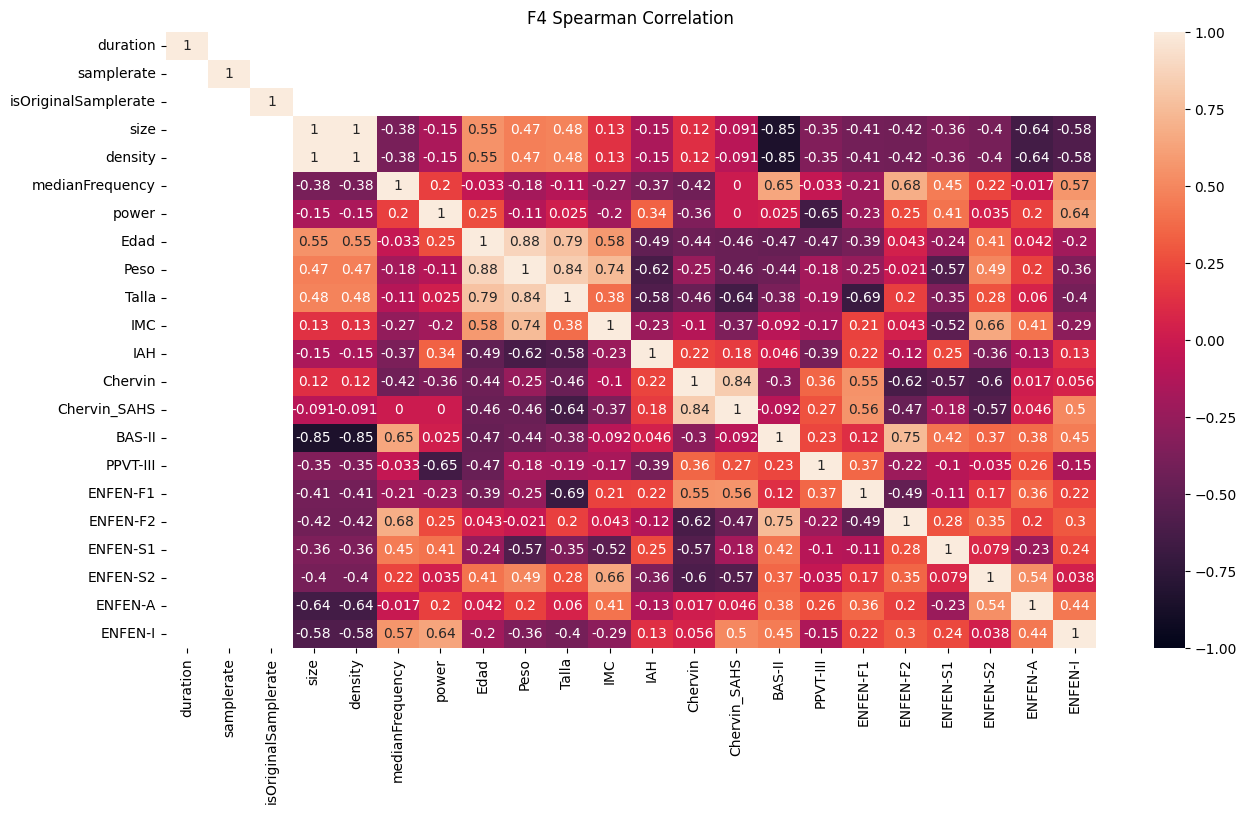

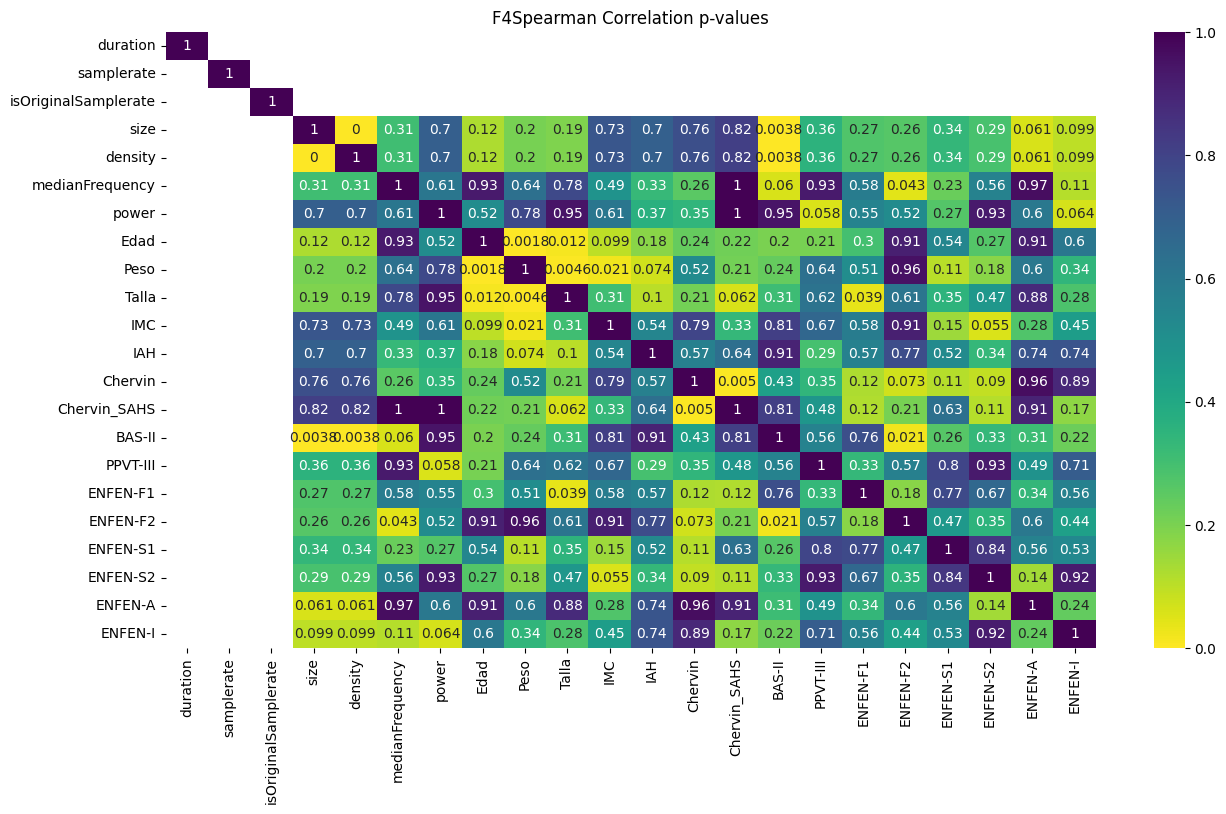

In [135]:
tests=pd.read_csv(cognipath+'/fullTests_3.csv')

for channel,df in aux.groupby('channel'):
    descriptors=pd.merge(df,tests,on='subjectId')
    
    #correlation matrices
    from scipy.stats import spearmanr
    def spearmanr_pval(x,y):
            return spearmanr(x,y)[1]

    def spearmanr_r(x,y):
            return spearmanr(x,y)[0]

    r=descriptors.corr(method=spearmanr_r)
    pval=descriptors.corr(method=spearmanr_pval)

    import seaborn as sns # For pairplots and heatmaps
    plt.figure(figsize=(15,8))
    heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
    plt.title(channel+" Spearman Correlation")

    plt.figure(figsize=(15,8))
    heatmap = sns.heatmap(pval, vmin=0, vmax=1, annot=True,cmap=plt.cm.get_cmap('viridis_r'))
    plt.title(channel+"Spearman Correlation p-values")

### Spindle density, global

In [108]:
aux=spindles[['subjectId','startTime']].groupby(['subjectId'],as_index=False).size()
aux

subjectId  size
0    COG001  2283
1    COG002   625
2    COG003  2912
3    COG004  1908
4    COG005  3084
5    COG006  1335
6    COG007  1507
7    COG008   457
8    COG009   578

In [109]:
aux2=spindles[['subjectId','medianFrequency']].groupby(['subjectId'],as_index=False).mean()
aux2

subjectId  medianFrequency
0    COG001        11.884804
1    COG002        12.775313
2    COG003        12.026810
3    COG004        12.252891
4    COG005        12.217101
5    COG006        13.060335
6    COG007        12.544195
7    COG008        12.529489
8    COG009        11.901898

In [114]:
aux3=spindles[['subjectId','power']].groupby(['subjectId'],as_index=False).mean()
aux3

subjectId       power
0    COG001  262.689851
1    COG002  332.666493
2    COG003  262.779573
3    COG004  182.256443
4    COG005  459.584440
5    COG006  602.662812
6    COG007  414.584916
7    COG008  345.677080
8    COG009  630.436568

In [110]:
subjectsMetadata=signalsMetadata[['subjectId','database','duration']].drop_duplicates().reset_index(drop=True)
subjectsMetadata

subjectId      database  duration
0     COG001  COGNITION_v2   39600.0
1     COG002  COGNITION_v2   39600.0
2     COG003  COGNITION_v2   39600.0
3     COG004  COGNITION_v2   39600.0
4     COG005  COGNITION_v2   39600.0
5     COG006  COGNITION_v2   39600.0
6     COG007  COGNITION_v2   39600.0
7     COG008  COGNITION_v2   39600.0
8     COG009  COGNITION_v2   39600.0
9     COG010  COGNITION_v2   25695.0
10    COG011  COGNITION_v2   37800.0
11    COG012  COGNITION_v2   39600.0
12    COG013  COGNITION_v2   39600.0
13    COG014  COGNITION_v2   39600.0
14    COG015  COGNITION_v2   39600.0
15    COG016  COGNITION_v2   39600.0
16    COG017  COGNITION_v2   39600.0
17    COG018  COGNITION_v2   39600.0
18    COG019  COGNITION_v2   41400.0

In [111]:
aux=pd.merge(subjectsMetadata,aux,on="subjectId")
aux["density"]=aux["size"]/(aux["duration"]/3600)

In [112]:
aux

subjectId      database  duration  size     density
0    COG001  COGNITION_v2   39600.0  2283  207.545455
1    COG002  COGNITION_v2   39600.0   625   56.818182
2    COG003  COGNITION_v2   39600.0  2912  264.727273
3    COG004  COGNITION_v2   39600.0  1908  173.454545
4    COG005  COGNITION_v2   39600.0  3084  280.363636
5    COG006  COGNITION_v2   39600.0  1335  121.363636
6    COG007  COGNITION_v2   39600.0  1507  137.000000
7    COG008  COGNITION_v2   39600.0   457   41.545455
8    COG009  COGNITION_v2   39600.0   578   52.545455

In [113]:
aux=pd.merge(aux,aux2,on="subjectId")
aux

subjectId      database  duration  size     density  medianFrequency
0    COG001  COGNITION_v2   39600.0  2283  207.545455        11.884804
1    COG002  COGNITION_v2   39600.0   625   56.818182        12.775313
2    COG003  COGNITION_v2   39600.0  2912  264.727273        12.026810
3    COG004  COGNITION_v2   39600.0  1908  173.454545        12.252891
4    COG005  COGNITION_v2   39600.0  3084  280.363636        12.217101
5    COG006  COGNITION_v2   39600.0  1335  121.363636        13.060335
6    COG007  COGNITION_v2   39600.0  1507  137.000000        12.544195
7    COG008  COGNITION_v2   39600.0   457   41.545455        12.529489
8    COG009  COGNITION_v2   39600.0   578   52.545455        11.901898

In [115]:
aux=pd.merge(aux,aux3,on="subjectId")
aux

subjectId      database  duration  size     density  medianFrequency  \
0    COG001  COGNITION_v2   39600.0  2283  207.545455        11.884804   
1    COG002  COGNITION_v2   39600.0   625   56.818182        12.775313   
2    COG003  COGNITION_v2   39600.0  2912  264.727273        12.026810   
3    COG004  COGNITION_v2   39600.0  1908  173.454545        12.252891   
4    COG005  COGNITION_v2   39600.0  3084  280.363636        12.217101   
5    COG006  COGNITION_v2   39600.0  1335  121.363636        13.060335   
6    COG007  COGNITION_v2   39600.0  1507  137.000000        12.544195   
7    COG008  COGNITION_v2   39600.0   457   41.545455        12.529489   
8    COG009  COGNITION_v2   39600.0   578   52.545455        11.901898   

        power  
0  262.689851  
1  332.666493  
2  262.779573  
3  182.256443  
4  459.584440  
5  602.662812  
6  414.584916  
7  345.677080  
8  630.436568

### Correlations

In [116]:
tests=pd.read_csv(cognipath+'/fullTests_3.csv')
tests

subjectId  Edad  Peso  Talla   IMC   Fecha_PSG   IAH  Chervin  \
0     COG001   6.7  28.0  124.0  18.2  28/01/2020  28.4     18.0   
1     COG002   7.3  31.0  130.0  18.3  04/02/2020  25.2      6.0   
2     COG003   8.7  40.5  132.0  23.2  25/02/2020   3.0     15.0   
3     COG004   8.1  36.0  138.0  18.9  26/02/2020   1.6      7.0   
4     COG005   9.6  33.8  138.0  17.7  04/03/2020   6.6      5.0   
5     COG006   7.6  28.0  125.0  17.9  05/03/2020  10.9      9.0   
6     COG007   7.5  32.0  135.0  17.6  10/03/2020   3.0     15.0   
7     COG008   6.4  17.0  113.0  13.3  11/03/2020   3.7     11.0   
8     COG009   6.6  23.0  127.0  14.3  12/03/2020  27.4     15.0   
9     COG010   9.8  55.5  146.0  26.0  23/06/2020   1.0     12.0   
10    COG011   7.5  27.0  130.0  16.0  24/06/2020   3.7      5.0   
11    COG012   7.0  24.0  122.0  16.1  21/10/2020   4.9     11.0   
12    COG013   7.0  20.0  119.0  14.1  04/11/2020   4.3      4.0   
13    COG014   7.1  16.3  130.0   9.6  16/12/2020   7.2     14.0   
14    COG015  10.4  30.8  132.0  17.7  28/01/2021   2.7     11.0   
15    COG016   7.5   NaN    NaN   NaN  10/02/2021   4.0      4.0   
16    COG017   7.7  27.2  127.0  16.9  11/03/2021   2.8      7.0   
17    COG018   8.3  18.0  110.0  14.9  15/04/2021   1.3     10.0   
18    COG019   6.8  25.0  128.0  15.3  03/07/2021   9.0      NaN   

    Chervin_SAHS  BAS-II  PPVT-III  ENFEN-F1  ENFEN-F2  ENFEN-S1  ENFEN-S2  \
0            1.0      87       100         6         3         4         1   
1            0.0     121        98         5         9         6         8   
2            1.0      87       103         7         3         3         7   
3            0.0     102       108         4         7         5         6   
4            0.0      55        89         1         5         7         5   
5            1.0     109        96         5         8         7         5   
6            1.0      95       101         3         6         3         1   
7            1.0     109       112         6         5         8         5   
8            1.0      98       107         5         5         6         1   
9            1.0      91       102         3         5         3         5   
10           0.0     137       118         4         9         5         6   
11           1.0      92       121         2         3         4         2   
12           0.0     101       109         2         4         4         2   
13           1.0      73        81         2         5         1         1   
14           1.0     133       133         5         6         8         5   
15           0.0      69       105         4         5         4         1   
16           0.0      92       111         6         7         6         3   
17           1.0      80        76         4         1         5         4   
18           NaN      99       107         7         6         7         4   

    ENFEN-A  ENFEN-I  
0         2        5  
1         5        7  
2         6        7  
3         4        4  
4         2        6  
5         4       10  
6         3        7  
7         3        7  
8         5        7  
9         4        2  
10        5       10  
11        1        7  
12        6        9  
13        4        4  
14        6        8  
15        2        5  
16        2        2  
17        4        3  
18        2        7

In [117]:
descriptors=pd.merge(aux,tests,on='subjectId')
descriptors

subjectId      database  duration  size     density  medianFrequency  \
0    COG001  COGNITION_v2   39600.0  2283  207.545455        11.884804   
1    COG002  COGNITION_v2   39600.0   625   56.818182        12.775313   
2    COG003  COGNITION_v2   39600.0  2912  264.727273        12.026810   
3    COG004  COGNITION_v2   39600.0  1908  173.454545        12.252891   
4    COG005  COGNITION_v2   39600.0  3084  280.363636        12.217101   
5    COG006  COGNITION_v2   39600.0  1335  121.363636        13.060335   
6    COG007  COGNITION_v2   39600.0  1507  137.000000        12.544195   
7    COG008  COGNITION_v2   39600.0   457   41.545455        12.529489   
8    COG009  COGNITION_v2   39600.0   578   52.545455        11.901898   

        power  Edad  Peso  Talla  ...  Chervin Chervin_SAHS  BAS-II  PPVT-III  \
0  262.689851   6.7  28.0  124.0  ...     18.0          1.0      87       100   
1  332.666493   7.3  31.0  130.0  ...      6.0          0.0     121        98   
2  262.779573   8.7  40.5  132.0  ...     15.0          1.0      87       103   
3  182.256443   8.1  36.0  138.0  ...      7.0          0.0     102       108   
4  459.584440   9.6  33.8  138.0  ...      5.0          0.0      55        89   
5  602.662812   7.6  28.0  125.0  ...      9.0          1.0     109        96   
6  414.584916   7.5  32.0  135.0  ...     15.0          1.0      95       101   
7  345.677080   6.4  17.0  113.0  ...     11.0          1.0     109       112   
8  630.436568   6.6  23.0  127.0  ...     15.0          1.0      98       107   

   ENFEN-F1  ENFEN-F2  ENFEN-S1  ENFEN-S2  ENFEN-A  ENFEN-I  
0         6         3         4         1        2        5  
1         5         9         6         8        5        7  
2         7         3         3         7        6        7  
3         4         7         5         6        4        4  
4         1         5         7         5        2        6  
5         5         8         7         5        4       10  
6         3         6         3         1        3        7  
7         6         5         8         5        3        7  
8         5         5         6         1        5        7  

[9 rows x 23 columns]

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_6060\1804215650.py:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_6060\1804215650.py:10: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Spearman Correlation p-values')

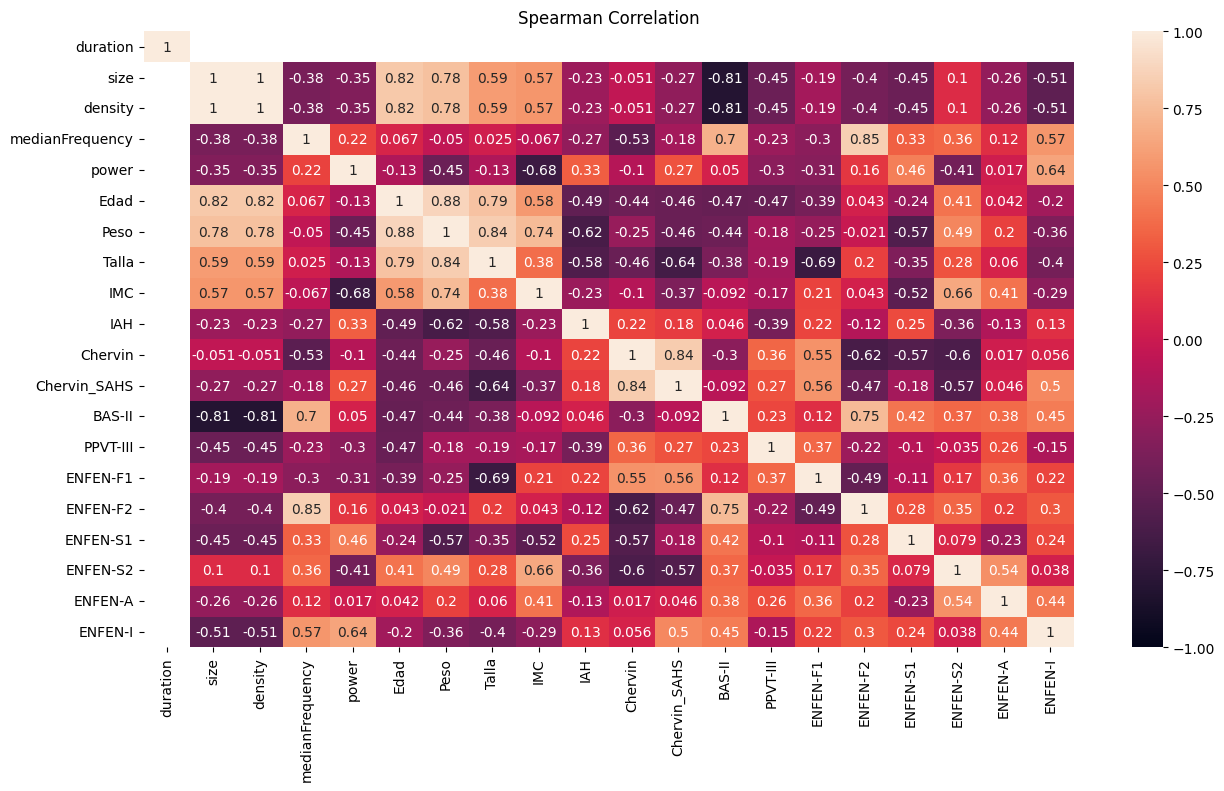

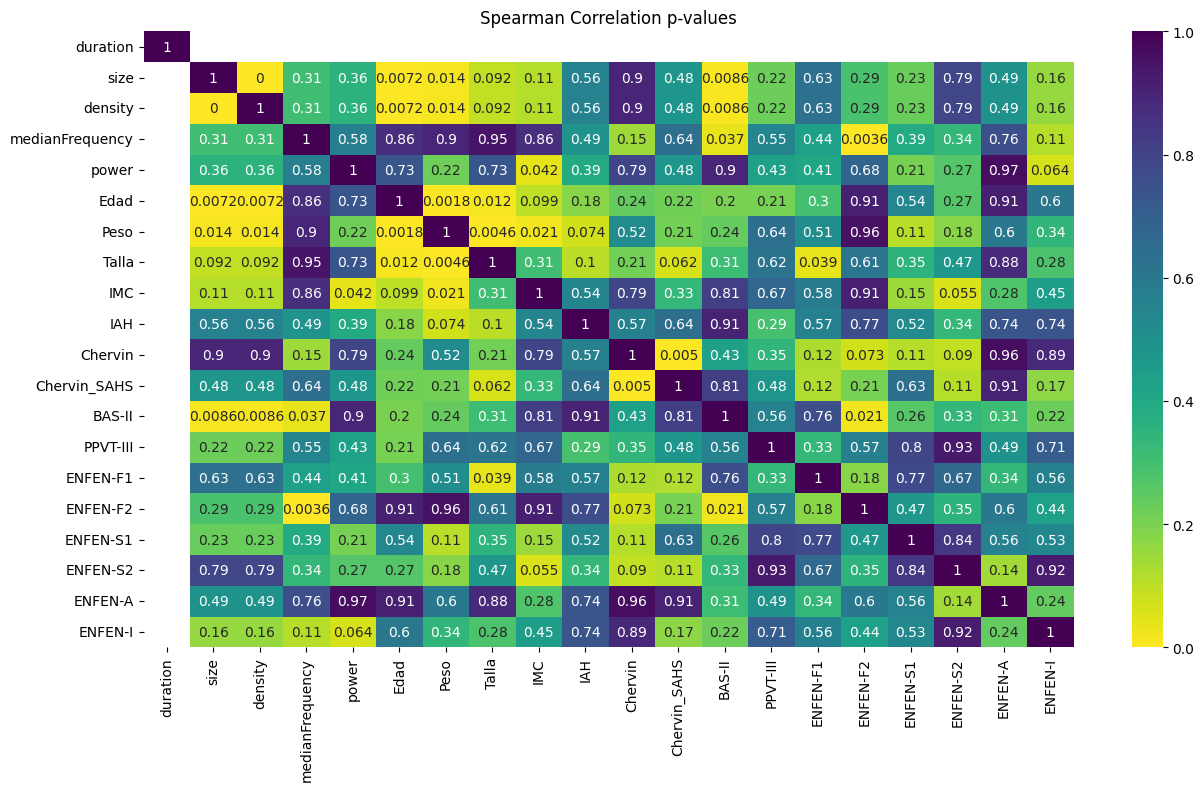

In [118]:
#correlation matrices
from scipy.stats import spearmanr
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

def spearmanr_r(x,y):
        return spearmanr(x,y)[0]

r=descriptors.corr(method=spearmanr_r)
pval=descriptors.corr(method=spearmanr_pval)

import seaborn as sns # For pairplots and heatmaps
plt.figure(figsize=(15,8))
heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
plt.title("Spearman Correlation")

plt.figure(figsize=(15,8))
heatmap = sns.heatmap(pval, vmin=0, vmax=1, annot=True,cmap=plt.cm.get_cmap('viridis_r'))
plt.title("Spearman Correlation p-values")

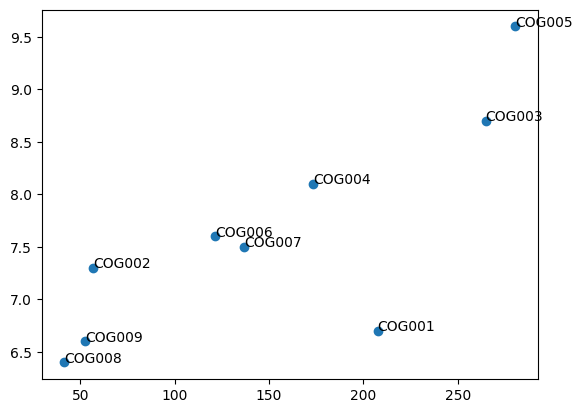

In [56]:
plt.plot(descriptors['density'],descriptors['Edad'],linestyle='',marker='o')
for x,y,text in zip(descriptors['density'],descriptors['Edad'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

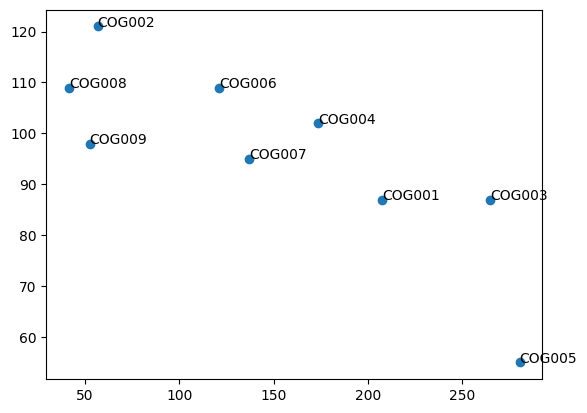

In [59]:
plt.plot(descriptors['density'],descriptors['BAS-II'],linestyle='',marker='o')
for x,y,text in zip(descriptors['density'],descriptors['BAS-II'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

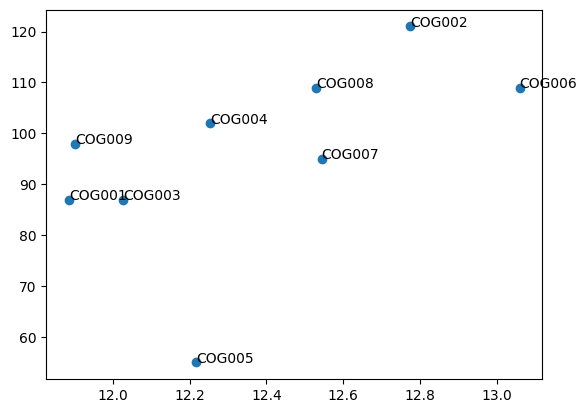

In [119]:
plt.plot(descriptors['medianFrequency'],descriptors['BAS-II'],linestyle='',marker='o')
for x,y,text in zip(descriptors['medianFrequency'],descriptors['BAS-II'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

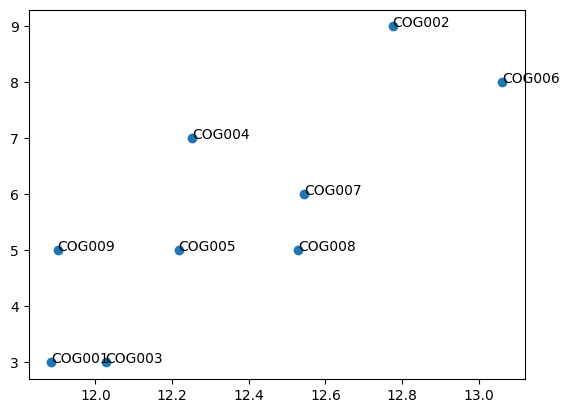

In [120]:
plt.plot(descriptors['medianFrequency'],descriptors['ENFEN-F2'],linestyle='',marker='o')
for x,y,text in zip(descriptors['medianFrequency'],descriptors['ENFEN-F2'],descriptors['subjectId']):
    plt.annotate(text,(x,y))